# Diffusion Models

* source1:https://blog.csdn.net/Peach_____/article/details/128663957
* source2:https://huggingface.co/blog/annotated-diffusion
* source3:https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

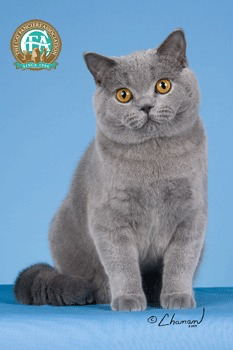

In [1]:
# 导入基本的包
from IPython.display import Image
Image(filename='Cats_Test0.png')

In [4]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import numpy as np
import torch
from torch import nn, einsum
import torch.nn.functional as F

# 一、DDPM基础

生成模型
* AutoEncoder
* GAN
* VAE
* DDPM(多层VAE)

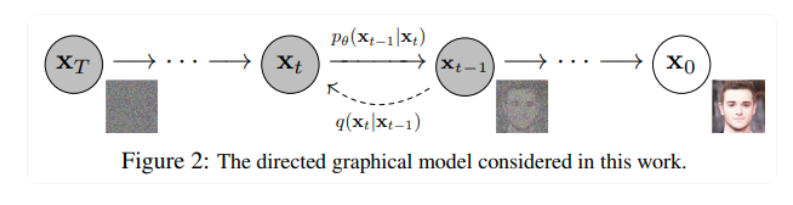

* 时间步数:T=1000

* $x_0$是真实样本数据(like a cat image)

* 前向过程(扩散过程):从每个时间t不断加高斯噪声
* 当T较大时,服从各向同性的高斯分布
* 各向同性的高斯分布（球形高斯分布）指的是各个方向方差都一样的多维高斯分布，协方差为正实数与identity matrix相乘。
* **各向同性的高斯每个维度之间也是互相独立的，因此密度方程可以写成几个1维度高斯乘积形式**

具体推导可以参考上面的3个链接

* 网络需要拟合的分布是$p_{\theta}(x_{t-1}|x_t)$

参数$\theta$:
* $\mu_{\theta}$
* $\sum_{\theta}$


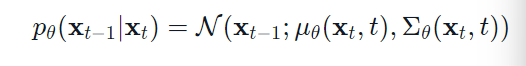

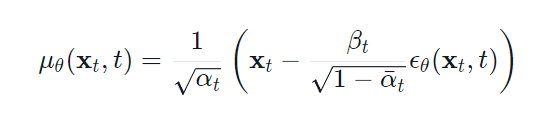

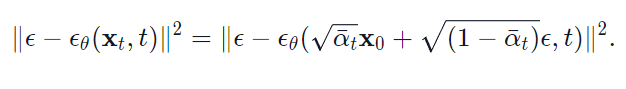

* 训练过程，拟合噪音

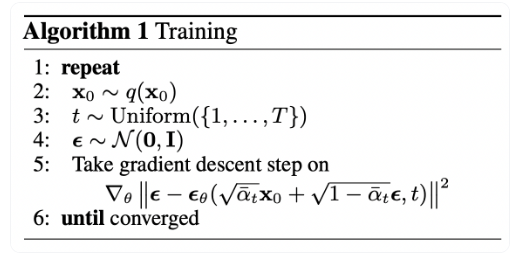

# 二、神经网络——拟合的模型U-Net

* 在一个特定的时间不长接受一个噪声图像
* 返回预测的噪声
* 预测的噪声是一个张量：具有与输入同样的大小维度
* 故模型网络的输入输出是相同形状的张量
* 通常使用的是自动编码器
* **自动编码器在编码器和解码器之间有一个“瓶颈层”**
* **编码器首先将输入编码为隐藏表示（瓶颈**--->瓶颈是用来学习最重要的信息
* **最后解码器将隐藏表示解码为实际输出**

**U-Net先降采样再升采样**

**很明显U-Net可以用transformer改进encoder-decoder**

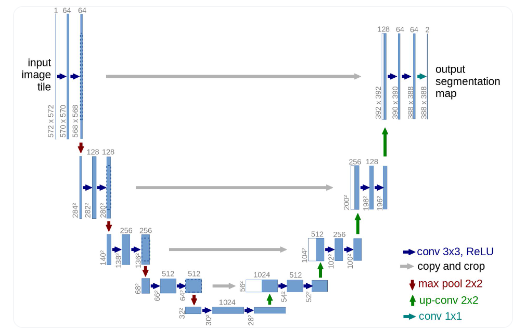

## 2.1 辅助函数和类

* isfunctions()根据输入是否为函数返回True,False

In [70]:
def exists(x):
    return x is not None # None-->False,else True

def default(val, d): # 该函数要么返回val，要么返回d()或d
    if exists(val): #若非none，则返回其值
        return val
    return d() if isfunction(d) else d

def num_to_groups(num, divisor):
    groups = num // divisor #返回商
    remainder = num % divisor # 返回余数
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


class Residual(nn.Module): # f(x) + x
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        # nn.init.constant_(self.fn.weight.data, 1)
        # nn.init.constant_(self.fn.bias.data, 0.0)
        # xavier_normal_
        # nn.init.xavier_normal_(self.fn.weight.data)
        # nn.init.constant_(self.fn.bias.data, 0.0)
        # # kaiming权重初始化
        # nn.init.kaiming_uniform_(self.fn.weight.data, a=0, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None): # 上采样
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),# _,_,2*h，2*w
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),# 宽高不变,-->_,dim,2*h，2*w
    )

def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )

**权重初始化**：
* nn.init.constant_(tensor, val)：常数初始化
* nn.init.uniform_(tensor, a=0, b=1):均匀分布初始化,a下界,b上界
* nn.init.normal_(tensor, mean=0, std=1):正态分布初始化,给定均值和标准差的正态分布N(mean, std)中生成值
* nn.init.xavier_uniform(tensor, gain=1):Xavier均匀分布,结果张量中的值采样自U(-a, a)，其中a= gain * sqrt( 2/(fan_in + fan_out))* sqrt(3). 
* nn.init.xavier_normal_(tensor, gain=1):Xavier 正态分布,果张量中的值采样自均值为0，标准差为gain * sqrt(2/(fan_in + fan_out))的正态分布
* nn.init.kaiming_uniform_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu'):kaiming 均匀分布
* nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu'):kaiming 正态分布
* nn.init.eye_(tensor):单位矩阵初始化
* nn.init.orthogonal_(tensor, gain=1):正交初始化
* nn.init.sparse_(tensor, sparsity, std=0.01):系数初始化,非零元素根据一个均值为0，标准差为std的正态分布生成。
* nn.init.dirac_(tensor):狄拉克δ函数初始化

In [54]:
x = torch.tensor([[1,2],[3,4]],dtype=torch.float32)
model  = Residual(nn.Linear(2,2))
y = model(x)

In [60]:
sample = nn.Upsample(scale_factor=2, mode='nearest')
sample(x.unsqueeze(0).unsqueeze(0)).shape

torch.Size([1, 1, 4, 4])

In [63]:
x_in = sample(x.unsqueeze(0).unsqueeze(0))

In [67]:
conv = nn.Conv2d(1, default(None, 3), 3, padding=1) 
x_out = conv(x_in)# [1,3,4,4]

In [68]:
x_out.shape

torch.Size([1, 3, 4, 4])

In [71]:
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce # 这个

**张量操作神器einops**
**einops的强项是把张量的维度操作具象化，让开发者“想出即写出”**
* einops.layers.torch导入的Rearrange, Reduce, Repeat主要是可以嵌入到pytorch的网络层里当成一个类似的网络模型用
* rearange和Rearange,-->从函数名称也可以看出是对张量尺度进行重排
* eniops中的rearrange,用于对张量‘显示’的处理，是一个函数
* einops.layers.torch中的Rearrange，用于搭建网络结构时对张量进行“隐式”的处理
* rearrange(images, 'b h w c -> b (h w) c')
* Rearrange('b e (h) (w) -> b (h w) e')，表示将4维张量转换为3维，且原来的最后两维合并为一维

* reduce：reduce(a, 't b c -> b c', 'max') #沿着维度t求最大值，对应的还有,min', 'max', 'sum', 'mean', 'prod'
* repeat:a = torch.randn(9, 9)  # [9, 9],output_tensor = repeat(a, 'h w -> c h w', c=3)  # [3, 9, 9]

In [81]:
image = torch.randn(1,2,3,2)  # torch.Size([1,2,3,2]) 
model = Rearrange('b c h w -> b (h w) c', c=2,h=3,w=2) #[1,6,2]
out = rearrange(image, 'b c h w -> b (c h w)', c=2,h=3,w=2) # torch.Size([1,12])
# h,w的值更改
# err1 = rearrange(image, 'b c h w -> b (c h w)', c=2,h=2,w=3) # 报错
# out1 = Rearrange(image)

In [80]:
Rearrange

einops.layers.torch.Rearrange

In [82]:
out1 = model(image)

In [83]:
out1.shape

torch.Size([1, 6, 2])

## 2.2 位置编码
* 对时间t进行编码
* 让模型 "知道 "它是在哪个特定的时间步长（噪声水平）下运行的

In [105]:
# 输入的维度是[batch_size,1],有几张图
# 返回输出的维度是[batch_size, dim]
# 该模块被加入到每个残差模块
class SinusoidalPositionEmbeddings(nn.Module): # 与transfomer的embedding是有区别的
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)#维度256
        embeddings = time[:, None] * embeddings[None, :] # 维度扩充为[1,256]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1) # [1,dim]or[1,dim-1]
        return embeddings

## 2.3 ResNet block

In [140]:
class WeightStandardizedConv2d(nn.Conv2d): # 标准化权重,其他默认
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean") # 通道，高，宽求均值，
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )
    
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x) #标准权重化卷积
        x = self.norm(x) # 通道分组归一化

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x) # 激活
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1) # 将channel维度切分成2块

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)

* torch.var求方差，unbiased无偏估计
* True使用的是第一个

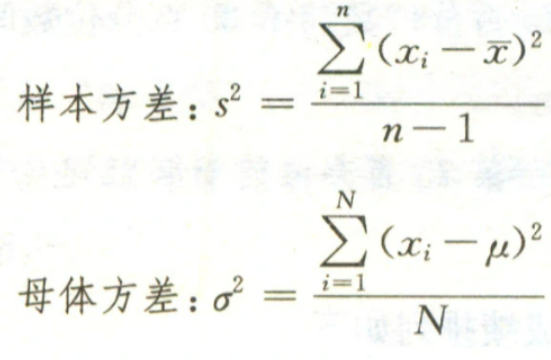

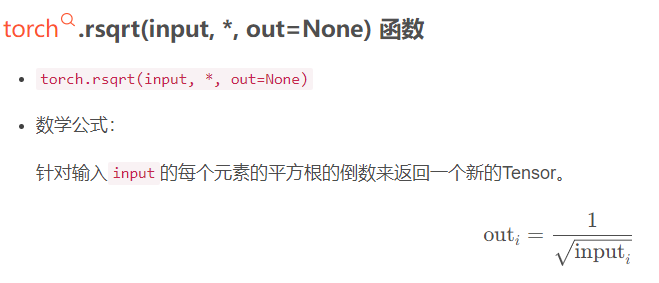

**归一化总结**:不改变原始数据的维度
* Batch Normalization（2015年）：是在batch上，对NHW做归一化，对小batchsize效果不好
* Layer Normalization（2016年）：在通道方向上，对CHW归一化，主要对RNN作用明显
* Instance Normalization（2017年）：在图像像素上，对HW做归一化，用在风格化迁移；
* Group Normalization（2018年）：将channel分组，然后再做归一化；
* Switchable Normalization（2018年）：是将BN、LN、IN结合，赋予权重，让网络自己去学习归一化层应该使用什么方法。

* nn.GroupNorm(num_groups,num_channels)：将channel切分成许多组进行归一化
* num_groups:组数
* num_channels:通道数量

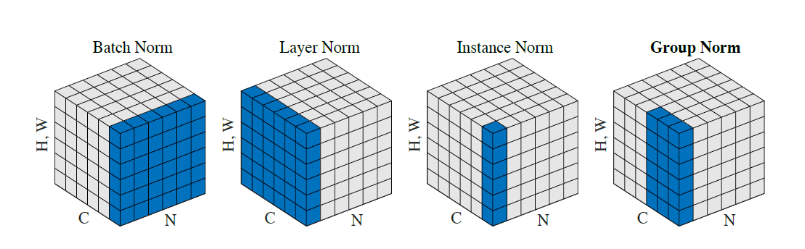

* torch.chunk:切分用来将tensor分成很多个块
* torch.chunk(tensor,chunk数，维度）#沿着维度进行切分

In [147]:
a = torch.rand(1,512,224,224)
# conv = WeightStandardizedConv2d(1,3,3,padding=1)
# a_out = conv(a) #[1,3,6,4]

In [148]:
model =ResnetBlock(dim=512, dim_out=256, time_emb_dim=512, groups=8)

In [150]:
model(a).shape

torch.Size([1, 256, 224, 224])

## 2.4 Attention module

In [163]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5 # 1/sqrt(32)
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1) # 分成3组分别为q,k,v
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale # [1,4,32,h*w]

        sim = einsum("b h d i, b h d j -> b h i j", q, k) # 点积[1,4,h*w,h*w]
        sim = sim - sim.amax(dim=-1, keepdim=True).detach() # [1,4,h*w,h*w]
        attn = sim.softmax(dim=-1) # [1,4,h*w,h*w]

        out = einsum("b h i j, b h d j -> b h i d", attn, v) # [1,4,h*w,32]
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w) # [1,4*132, h, w]
        return self.to_out(out) # [1,3,h,w]
    
class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )#[1,4,32,h*w]

        q = q.softmax(dim=-2)#[1,4,32,h*w]
        k = k.softmax(dim=-1)#[1,4,32,h*w]

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v) #[1,4,32,32]

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)# [1,4,32, h*w]
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w) # #[1,4*32,h,w]
        return self.to_out(out)# #[1,3,h,w]

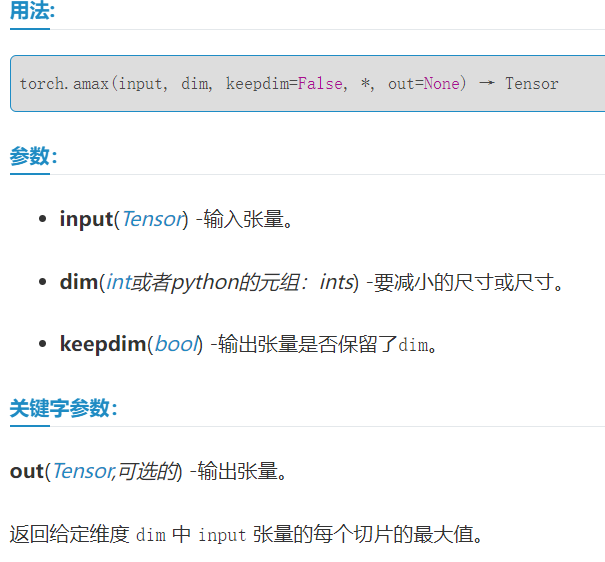

In [166]:
x = torch.rand(1,3,224,224)
dim =3
b, c, h, w = x.shape
heads=4
dim_head=32
hidden_dim = dim_head * heads #128
to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False) # 128*3

In [165]:
model = LinearAttention(dim=3, heads=4, dim_head=32)

In [167]:
model(x).shape

torch.Size([1, 3, 224, 224])

## 2.5 Group normalization

* Transformer是在注意力之前归一化还是在之后归一化还有争议

我认为是在之后

In [168]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

## 2.6 Conditional U-Net

输入有多张图片：
* [batch_size, 3, h, w]
* 噪声:[batch_size, 1]-->此处是batch_size

输出:
* [batch_size, 3, h, w]

* 首先：卷积层用于噪声图像，位置编码计算噪声水平
* 然后:下采样阶段
2 ResNet blocks 

groupnorm 

attention 

residual connection 

a downsample operation

* 然后上采样
2 ResNet blocks 

groupnorm 

attention 

residual connection 

an upsample operation

* 最后一层一层叠加


In [210]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels # 输入的通道数
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim) # 
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0) # changed to 1 and 0 from 7,3

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] # [None, 3, 6, 12, 24]
        in_out = list(zip(dims[:-1], dims[1:])) # [(None, 3), (3, 6), (6, 12), (12, 24)]

        block_klass = partial(ResnetBlock, groups=resnet_block_groups) #分4组

        # time embeddings
        time_dim = dim * 4 # dim = 32

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # layers
        self.downs = nn.ModuleList([]) # 4个
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1] # 24
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1) # 维度增加

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

In [174]:
dim_mults = (1, 2, 4, 8)
init_dim = None
dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
list(zip(dims[:-1], dims[1:]))

[(None, 3), (3, 6), (6, 12), (12, 24)]

In [175]:
dims

[None, 3, 6, 12, 24]

In [176]:
dims[:-1]

[None, 3, 6, 12]

In [177]:
dims[1:]

[3, 6, 12, 24]

In [178]:
ResnetBlock?

Init signature: ResnetBlock(dim, dim_out, *, time_emb_dim=None, groups=8)
Docstring:      https://arxiv.org/abs/1512.03385
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           d:\研究生生涯\学习\时间序列异常检测\transformer-ddpm\untitled.ipynb
Type:           type
Subclasses:     

In [211]:
model = Unet(dim=32,
             init_dim=None,
             out_dim=None,
             dim_mults=(1, 2, 4, 8),
             channels=3,
             self_condition=False,
             resnet_block_groups=4,).to(device)

In [197]:
device = torch.device('cuda')

In [214]:
x = torch.rand(1,3,224,224).to(device)
time = torch.tensor([100])
time = time.to(device)

In [215]:
time.size()

torch.Size([1])

In [216]:
noise = model(x, time)

In [218]:
noise.shape

torch.Size([1, 3, 224, 224])

# 三、前向过程

* 逐渐向真实数据加入噪音
* 加噪音的时间步数为T=1000
* 最初方差调度是线性的：[10^-4, 0.02]
* 2021年采用余弦调度：cosine schedule

## 3.1 $\beta_s$

In [5]:
# 定义方差调度

# 余弦调度
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)#[0,1,2,...,1001]
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2 #[1001,]
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1]) #[1000,]
    return torch.clip(betas, 0.0001, 0.9999)

# 线性调度
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [5]:
import torch
torch.linspace(0, 1000,1)

tensor([0.])

In [6]:
cos_betas = cosine_beta_schedule(timesteps=1000, s=0.008)
ln_betas = linear_beta_schedule(timesteps=1000)
qd_betas = quadratic_beta_schedule(timesteps=1000)
sg_betas = sigmoid_beta_schedule(timesteps=1000)

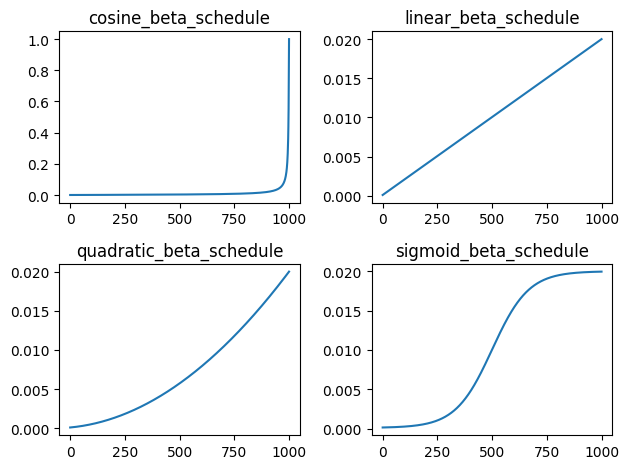

In [7]:
fig, axs = plt.subplots(2,2)
ax1 = axs[0,0]
ax1.plot(cos_betas)
ax1.set_title('cosine_beta_schedule')

ax2 = axs[0,1]
ax2.plot(ln_betas)
ax2.set_title('linear_beta_schedule')

ax3 = axs[1,0]
ax3.plot(qd_betas)
ax3.set_title('quadratic_beta_schedule')

ax4 = axs[1,1]
ax4.plot(sg_betas)
ax4.set_title('sigmoid_beta_schedule')
# plt.subplots_adjust(bottom=0.1, right=1.2, top=1.2)
plt.tight_layout()

## 3.2 **计算前向过程的相关变量**

* alphas-->$\alpha_t$
* alphas_cumprod-->$\prod_{i=1}^{T}\alpha_i$
* alphas_cumprod_prev-->$\prod_{i=0}^{T-1}\alpha_i$-->$\alpha_0=1$
* sqrt_recip_alphas-->$\frac{1}{\sqrt{\alpha_t}}$
* sqrt_alphas_cumprod-->$\sqrt{\prod_{i=1}^{T}\alpha_i}$
* sqrt_one_minus_alphas_cumprod-->$\sqrt{1-\prod_{i=1}^{T}\alpha_i}$
* posterior_variance-->$\hat{\beta_t} = \beta_t*(1-\prod_{i=0}^{T-1}\alpha_i)/(1-\prod_{i=1}^{T}\alpha_i)$

In [14]:
# T
timesteps = 1000
# betas
betas = linear_beta_schedule(timesteps=timesteps)
# alphas
alphas = 1. - betas
# 累乘alphas
alphas_cumprod = torch.cumprod(alphas, axis=0) # 注意该变量为所有步数的累乘维度为1000，只有最后一个数才是所有alpha的累乘值
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # [1,alpha_1,...,alpha_1*..*alpha_999] #[1000,]


sqrt_recip_alphas = torch.sqrt(1.0 / alphas) #1/根号alpha_t,[1000,]
# 开根号（累乘alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) #[1000,]
# 开根号（1-累乘alphas)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# 计算后验分布的方差beta_t的后验估计-->(1-alphas_cumprod_prev)/(1-alphas_cumprod)*betas
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # [1000,]

def extract(a, t, x_shape): # 暂不清楚他的作用
    batch_size = t.shape[0] # 1
    out = a.gather(-1, t.cpu()) #torch.gather(input, dim, index, out=None) → Tensor
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

**$x_0$-->以图片为例**

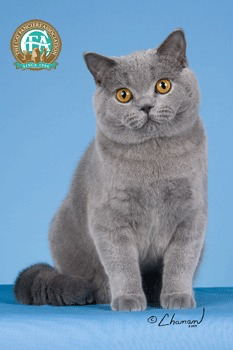

In [8]:
from PIL import Image
img = Image.open('Cats_Test0.png')
img

**注意到：噪声是加到pytorch的张量，而不是 Pillow Images中**

**数据预处理：transformation**

* img的数值在[0,255]，接下来需要将其值线性缩放到[-1,1]
* **保证模型在逆扩散过程模型从标准正态先验分布$p(x_T)$开始**-->不是很懂

#source:https://blog.csdn.net/qq_38410428/article/details/94719553?spm=1001.2101.3001.6661.1&utm_medium=distribute.pc_relevant_t0.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-1-94719553-blog-101108427.pc_relevant_vip_default&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-1-94719553-blog-101108427.pc_relevant_vip_default&utm_relevant_index=1
**对PIL图像进行操作:torchvision.transforms包**：
like a model-->you should model(img)进行变换
* PIL图像image--np.array(img)-->[h,w,c]
* PIL图像的size返回的是[w,h]-->img.size-->[w,h]

* Compose([]):要组成的变换列表-->Compose([Resize(), ToTensor()])
* Resize-->:Resize([h,w])-->Resize(size, interpolation=2)

**裁剪(Crop)**：
* CenterCrop:中心裁剪,CenterCrop(size) ,给定的size从中心裁剪 参数： size- (sequence or int)，若为sequence,则为(h,w)，若为int，则(size,size)
* RandomCrop:随机裁剪
* RandomResizedCrop：随机长宽比裁剪
* FiveCrop：上下左右中心裁剪
* TenCrop：上下左右中心裁剪后翻转

**翻转和旋转(Flip and Rotation)**:
* RandomHorizontalFlip(p=0.5):依概率p水平翻转
* RandomVerticalFlip(p=0.5):依概率p垂直翻转
* RandomRotation:随机旋转

**图像变换**：
* Resize:缩放大小,Resize(size, interpolation=2)
* Normalize：标准化,Normalize(mean, std),变换将标准化输入的每个通道
* ToTensor：转为tensor，并归一化至[0-1],将PIL Image或者 ndarray 转换为tensor，并且归一化至[0-1] 注意事项：归一化至[0-1]是直接除以255，若自己的ndarray数据尺度有变化，则需要自行修改。
* Pad：填充
* ColorJitter：修改亮度、对比度和饱和度
* Grayscale：转灰度图
* LinearTransformation()：线性变换
* RandomAffine：仿射变换
* RandomGrayscale：依概率p转为灰度图
* ToPILImage：将数据转换为PILImage
* Lambda：Apply a user-defined lambda as a transform.

**对transforms操作，使数据增强更灵活**：
* RandomChoice(transforms)：从给定的一系列transforms中选一个进行操作
* RandomApply(transforms, p=0.5)：给一个transform加上概率，依概率进行操作 
* RandomOrder：transforms中的操作随机打乱

In [12]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
image_size = 128
transform = Compose([
    Resize(image_size), #[h',128,3]or[128,w',3],PIL img
    CenterCrop(image_size),#[128,128,3],PIL img
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255-->[3,128,128]
    Lambda(lambda t: (t * 2) - 1), # 直接将里面的元素[0,1]*2-1-->[-1,1]
    
])

x_start = transform(img).unsqueeze(0) # [1,3,128,128]
x_start.shape

torch.Size([1, 3, 128, 128])

In [17]:
# 反转变换，将上述得到的tensor反转为PIL img
import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2), # [0,1],CHW
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.), #[0,255]
     Lambda(lambda t: t.numpy().astype(np.uint8)), 
     ToPILImage(),
])

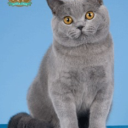

In [332]:
reverse_transform(x_start.squeeze())

## 3.3 定义前向过程

输入:
* x_0-->[1, 3, 128,18]-->[batch_size,通道,h,w]
* noise

In [334]:
noise = torch.randn_like(x_start) # 标准正态分布

In [335]:
noise.shape

torch.Size([1, 3, 128, 128])

In [346]:
extract(sqrt_alphas_cumprod, torch.tensor([1]), x_start.shape).shape

torch.Size([1, 1, 1, 1])

In [349]:
t = torch.tensor([40])
t.shape[0]

1

In [351]:
t

tensor([40])

In [350]:
t.cpu()

tensor([40])

In [352]:
sqrt_alphas_cumprod[1]

tensor(0.9999)

In [365]:
out = sqrt_alphas_cumprod.gather(-1,torch.tensor([1,2]).cpu())

In [366]:
out

tensor([0.9999, 0.9998])

In [361]:
(1,) * (len(x_start.shape) - 1)

(1, 1, 1)

In [360]:
out.reshape(1, *((1,) * (len(x_start.shape) - 1)))

tensor([[[[0.9999]]]])

**根据x_0，,t,noise计算x_t**

In [9]:
def extract(a, t, x_shape): # 暂不清楚他的作用
    batch_size = t.shape[0] # t可以取多个值like torch.tensor([1,2,...,])
    # 取t时刻的累乘值
    # gather高级切片
    out = a.gather(-1, t.cpu()) #torch.gather(input, dim, index, out=None) → Tensor
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)



def q_sample(x_start, t, noise=None):
    """
    x_start，t都是张量
    return x_t
    
    """
    if noise is None:
        noise = torch.randn_like(x_start) # [1, 3, 128, 128]
    # 提取对应时刻t的开根号累乘alpha值  
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape) 
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

**获取加噪后的PIL图片**

In [16]:
def get_noisy_image(x_start, t):
    # add noise
    # x_t
    x_noisy = q_sample(x_start, t=t) # [1,3,128,128]
    # turn back into PIL image
    noisy_image = reverse_transform(x_noisy.squeeze())
    return noisy_image # PIL img

In [18]:
t = torch.tensor([40]) #注意到索引为40，其实是第41步即t=41
noisy_image_41 = get_noisy_image(x_start, t)

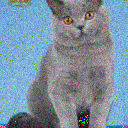

In [19]:
noisy_image_41

In [20]:
t = torch.tensor([999]) 
noisy_image_1000 = get_noisy_image(x_start, t)

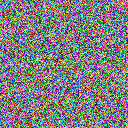

In [21]:
noisy_image_1000

**可视化不同时间的加噪图片**

In [390]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(42)
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs) #1
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs): # row是图片列
        # row = [image] + row if with_orig else row
        row = [img] + row if with_orig else row # 加上了原始的图片if with_orig
        for col_idx, img1 in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img1), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

* np.array和np.asarray都可将结构数据转换为ndarray类型。

* 但是主要区别就是当数据源是ndarray时，
* array仍会copy出一个副本，占用新的内存，但asarray不会。

In [391]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 99, 499, 799, 999]],
    with_orig=True, row_title=None)

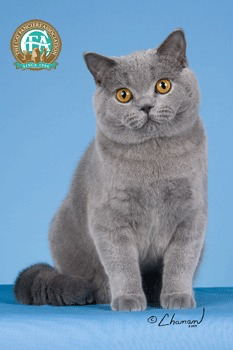

In [389]:
img

## 3.4 定义模型训练损失

In [395]:
# 损失是第t步的
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)
    # 第t步加噪后的图片
    # [1,3,128,128]
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise) # 这里是有问题的
    # 预测出的噪音后的图片
    predicted_noise = denoise_model(x_noisy, t)  # 但问题可能是等价的

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

## 3.5 定义pytorch Dataset + DataLoader

In [396]:
from datasets import load_dataset
# load dataset from the hub
dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128

Found cached dataset fashion_mnist (C:/Users/xionglang2023/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [424]:
train = dataset['train'] # 60000,28*28
test = dataset['test']   # 10000, 28*28

In [448]:
from torchvision import transforms
from torch.utils.data import DataLoader
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),#[1,28,28]
            transforms.Lambda(lambda t: (t * 2) - 1)
])
# define function
def transforms(examples):
    # examples["image"],like train['image'] is a list
    # 转化成张量后删除原来的pil图片
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]
    return examples
transformed_dataset = dataset.with_transform(transforms).remove_columns("label")
# create dataloader
# 每一批有128个，即[128,1,28,28]
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)


PIL图像处理：convert(‘L‘)函数原理：
img = img.convert()：
* 1，L，P，RGB，RGBA，CMYK，YCbCr，I，F。
* 1：非黑即白，二值图像
* L:为灰度图像，每个像素用8个bit表示，0表示黑，255表示白，其他数字表示不同的灰度。
转换公式：L = R * 299/1000 + G * 587/1000+ B * 114/1000。


# 四、逆扩散过程

## 4.1 采样（从白噪声开始采样）

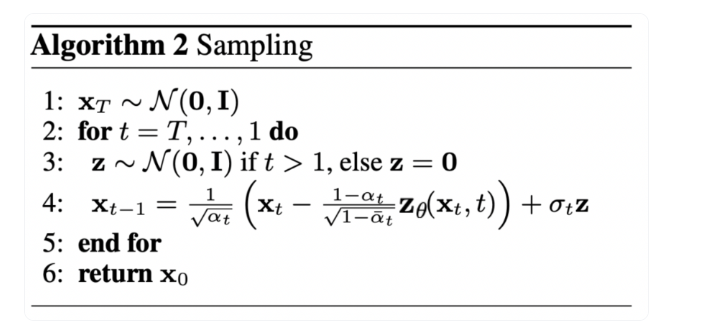

* X_T时刻是白噪声
* 我们可以推导出如下

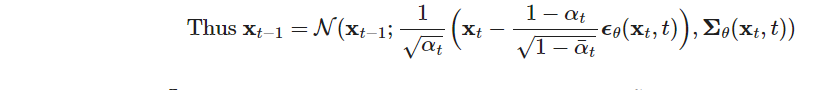

* 重参数化mean

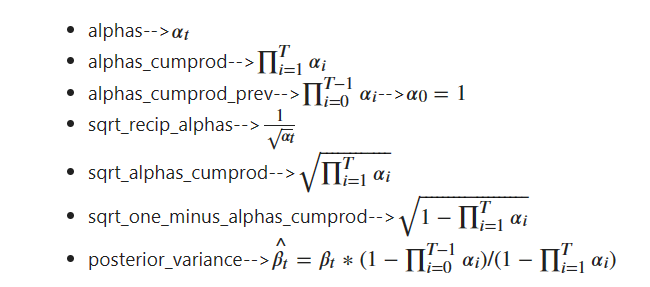

In [453]:
@torch.no_grad() # 无梯度
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape) # 取真实的t时刻的beta
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    ) # 取t时刻的开根号1-累乘alphas
    # 取t时刻之前的开根号1/alphas
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape) # 取估计的beta_t
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise # 返回x_(t-1)

# Algorithm 2 (including returning all images)，#返回求出来的所有图片
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device) #从白噪声开始回退
    imgs = []
    # 调用了1000次model明显太慢
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs #[1000,]

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


## 4.2 训练模型

In [454]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

**模型采用gpu加速，优化器采用Adam**

In [457]:
from torch.optim import Adam
device = "cuda" if torch.cuda.is_available() else "cpu"

In [459]:
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

**开始训练**

In [473]:
# 损失是第t步的
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)
    # 第t步加噪后的图片
    # [1,3,128,128]
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    # 预测出的噪音后的图片
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [478]:
from torchvision.utils import save_image
epochs = 3
torch.manual_seed(42)
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        batch_size = batch["pixel_values"].shape[0] 
        batch = batch["pixel_values"].to(device)#[128,1,28,28]
        # 单独使用t是随机打乱的，且每次不一样，在一个单元块是一样的(128,)
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        loss = p_losses(model, batch, t, loss_type="huber")
        if step % 100 == 0:
            print("Loss:", loss.item())
        loss.backward()
        optimizer.step()
        if step != 0 and step % save_and_sample_every == 0:
            milestone = step // save_and_sample_every
            batches = num_to_groups(4, batch_size) # [4]
            #[4,1,28,28]
            all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
            all_images = torch.cat(all_images_list, dim=0) #[[1000,],...]
            all_images = (all_images + 1) * 0.5 # 恢复到0到1的数值
            save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

Loss: 0.4160554111003876
Loss: 0.042497050017118454
Loss: 0.025911660864949226
Loss: 0.02518470399081707
Loss: 0.02407608926296234
Loss: 0.01852700300514698
Loss: 0.026963353157043457
Loss: 0.027054863050580025
Loss: 0.0241280235350132
Loss: 0.026416929438710213
Loss: 0.023302054032683372
Loss: 0.01978343352675438
Loss: 0.020058492198586464
Loss: 0.01993684284389019
Loss: 0.01945432275533676


## 4.3采样（推理）

In [479]:
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [480]:
dataset['train'][0]['image']

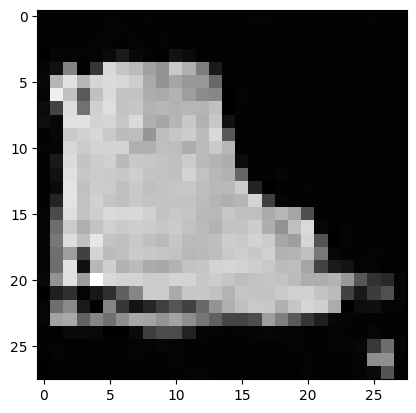

In [496]:
random_index = 5
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

MovieWriter ffmpeg unavailable; using Pillow instead.


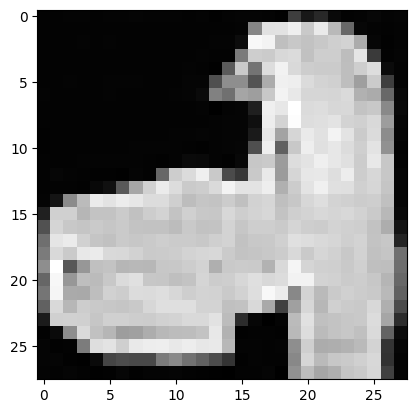

In [497]:
import matplotlib.animation as animation

random_index = 53

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()

In [500]:
torch.__version__

'1.11.0+cu115'